<h1 align='center'>Songs Sentimental Analysis and Recommendation</h1>
<h1 align='center'>Based on Lyrics and Comments </h1>

<h3 align='center'>Team 6: Akshay Mali, Arshia Pelathur, N Abhishek & Suvarna Satish</h3>

<img src="Poster_Image.gif" width="750" align="center">

## Summary

- Human beings have ability to think, understand, make decisions and give their view points on mostly everything. Having this reasoning and decision making ability, the sentiments of humans are effected by almost everything, maybe positive or negative.


- The study of these sentiments of human beings is handled under the field of machine learning, NLP  and many more. 


- This makes utilization of content examination and effectively distinguish, evaluate, concentrate and study emotional states and subjective data.


- Sentiment analysis may be done on various subjects like, movie reviews, twitter (tweets), any text document, comments, public statements or music.


- In this Analysis we are going to discuss various Natural Language concepts used in study of sentiment analysis of a musical lyrics and user comments. 

## Table of contents

#### 1. Importing Libraries
#### 2. Web Scrapping
#### 3. Data Cleaning
#### 4. Exploratory Data Analysis
#### 5. Data Pre-Processing
#### 6. Bag of words analysis on Lyrics
#### 7. Sentiment Analysis using Rule Based Algorithm
#### 8. Word Cloud Analysis
#### 9. Comparing sentiment of Song lyrics and comments
#### 10. Topic modeling on lyrics using Latent Dirichlet Allocation (LDA)
#### 11. Conclusion

## 1. Importing Libraries

In [97]:
import pandas as pd
import numpy as np
import requests
import bs4
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from IPython.display import clear_output
from time import sleep
from matplotlib import pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist
import gensim
from gensim import corpora, models, similarities
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning, module='sklearn') 
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

In [2]:
plt.rcParams['figure.figsize'] = [20,6]#graph size

# 2. Web Scraping

#### Website URL : https://songmeanings.com/

- Songmeanings.com contains millions of songs lyrics and comments. To obtain song lyrics/comments, we need to obtain the URLs to the song lyrics/comments page.


- We will use a small premade website index info file (sm_start_info.xlsx) to build out a list of URLs to the A-Z artist directory pages. 


- From there, we will use BeautifulSoup to webscrape the URLs

In [3]:
# We will use a small premade website index info file (sm_start_info.xlsx) 
#to build out a list of URLs to the A-Z artist directory pages.
start_info = pd.read_csv('sm_start_info.csv')#loading the dataset
start_info.head()

,letter,pages
0,a,16
1,b,17
2,c,15
3,d,16
4,e,8


#### Letter : All the artist whoes names starts with letter A
#### pages  : Total pages corresponding to that letter

In [4]:
# Build list of URLs to access artist directories
artist_dir_urls = []#empty list
for letter, max_page in start_info.values:#letter and the maximum pages
    for page in np.arange(1,max_page+1):#looping throug all the pages
        artist_dir_urls.append('https://songmeanings.com/artist/directory/'+letter+'/?page='+str(page))#appending the url to the empty list
artist_dir_urls[:5]#first 5 observations

['https://songmeanings.com/artist/directory/a/?page=1',
 'https://songmeanings.com/artist/directory/a/?page=2',
 'https://songmeanings.com/artist/directory/a/?page=3',
 'https://songmeanings.com/artist/directory/a/?page=4',
 'https://songmeanings.com/artist/directory/a/?page=5']

In [5]:
len(artist_dir_urls)#Total pages

235

### Below is the Sample page of one of the above URL

#### Contains all the Artist name starting from 'A'

<img src="Artist_Page_Directory.jpg" width="750" align="center">

#### Similary we have the rest of the URLs for other letters

In [6]:
# Build list of URLs to artist pages (name and URL)
SCRAPE_ARTIST_URLS = False # Set to False if scraping is already completed

if SCRAPE_ARTIST_URLS == True:#webscraping is needed
    artist_urls = []#empty list for appending
    for artists_page in artist_dir_urls:#looping through the url one by one
        page = requests.get(artists_page)#we get <Response [200]> status means that your request was successful (library uesd :import requests) 
        soup = BeautifulSoup(page.text, 'lxml')#Beautiful Soup is a Python library for pulling data out of HTML and XML files.(library uesd :import bs4 from bs4 import BeautifulSoup) 
        table = soup.find('table', summary='songs table')#soup.find finds the table tag with summary='songs table'
        table_body = table.find('tbody')#in the table find the tbody tag
        for item in table_body.find_all('a', href=True):#in the table_body finding the anchor tag
            artist_urls.append([(item['title']),(item['href'])])#inside the anchor tag appening the values of the href and title in the artist_urls list
        print ('Scraping artist URLs: '+artists_page)#print to observer which link is in progress
        clear_output(wait=True)#the widget contents are not cleared immediately. Instead, they are cleared the next time the widget receives something to display.(libray used :from IPython.display import clear_output)
        sleep(1)# suspends execution for the given number of seconds.(libray used :from time import sleep)
    # Save artist URL list
    artist_urls_df = pd.DataFrame(artist_urls)#building it into a dataframe
    artist_urls_df.to_csv('artist_urls.csv', index=False, header=False)#saving it into the csv file
else:
    artist_urls_df = pd.read_csv('artist_urls.csv', header=None)#if scraping is already done than the it will run the file

### Scraping of URL's for Individual Artists

#### For example we have scraped the URL '//songmeanings.com/artist/view/songs/6024/' for the Artist 'A'  as shown below

<img src="Artist_URLs.jpg" width="750" align="center">

In [7]:
artist_urls_df.columns = ['Artist','URL']#inserting the column names
artist_urls_df.head()#first 5 observations

,Artist,URL
0,A,//songmeanings.com/artist/view/songs/6024/
1,A B,//songmeanings.com/artist/view/songs/137439043...
2,A B & The Sea,//songmeanings.com/artist/view/songs/137438996...
3,A Backward Glance On A Travel Road,//songmeanings.com/artist/view/songs/137439060...
4,A Balladeer,//songmeanings.com/artist/view/songs/137438972...


In [8]:
len(artist_urls_df)#total records or total artist

11750

In [9]:
# Build list of URLs to song pages (Artist ,Song , song url , Number of comments)
SCRAPE_SONG_URLS = False # Set to False if scraping is already completed
song_urls=[]#empty list
if SCRAPE_SONG_URLS == True:#webscraping is needed


    for count, artist in enumerate(artist_urls_df.values):## Pythonic for loops when you need a count and the value from an iterable.
        page = requests.get('http:'+artist[1])#appending http in the artist url to  get <Response [200]> status means that your request was successful (library uesd :import requests)
        soup = BeautifulSoup(page.text, 'lxml')#Beautiful Soup is a Python library for pulling data out of HTML and XML files.(library uesd :import bs4 from bs4 import BeautifulSoup) 
        table = soup.find('table', summary='songs table')#soup.find finds the table tag with summary='songs table'
        if table != None:#if it finds the table follow below
            table_body = table.find('tbody')#in the table find the tbody tag
            for item in table_body.find_all('tr'):##.findAll finds all the tr tag and looping through each tr tag
                song_name = item.find_all('a')[0].contents[0]#find all the anchor tags and in the first anchor tag find the first conent
                song_url = item.find_all('a')[0]['href']#find all the anchor tags and in the first anchor tag the href link
                num_comments = item.find_all('a')[1].contents[0]#find all the anchor tags and in the second anchor tag find the first conent
                song_urls.append([artist[0], song_name, song_url, num_comments])#appending the artist name, song name , song url and the number of comments
        print('Scraping song URLs for artist: '+artist[0])#print to observer which link is in progress
        clear_output(wait=True)##the widget contents are not cleared immediately. Instead, they are cleared the next time the widget receives something to display.(libray used :from IPython.display import clear_output)
        sleep(2)# suspends execution for the given number of seconds.(libray used :from time import sleep)


    song_urls_df = pd.DataFrame(song_urls)#building it into a dataframe
    song_urls_df.to_csv('song_urls.csv', index=False, header=False)#saving it into the csv file
else:
    song_urls_df = pd.read_csv('song_urls.csv', header = None)#if scraping is already done than the it will run the file

### For a Particaluar Artist we are scraping the list of songs and its corresponding link and the number of comments

<img src="Artist_Page.jpg" width="750" align="center">

In [10]:
song_urls_df.columns = ['Artist','Song','URL','Number of comments']#inserting the column names
song_urls_df.head()#first 5 observations

,Artist,Song,URL,Number of comments
0,A,"""meditacao"" - (eng: Meditation)",//songmeanings.com/songs/view/91590/,0
1,A,2nd Coming,//songmeanings.com/songs/view/3530822107859283...,0
2,A,40,//songmeanings.com/songs/view/3530822107858486...,0
3,A,6 O'clock On A Tube Stop,//songmeanings.com/songs/view/93649/,1
4,A,8 Fingers,//songmeanings.com/songs/view/3530822107858486...,2


In [11]:
len(song_urls_df)#total songs 

42614

In [12]:
len(song_urls_df[song_urls_df['Number of comments']>=1])#songs having more than 1 comment

8650

In [13]:
# Functions to extract strings (exclude tagged items) from soup items
def extract_str(soup_item):
    string = []#empty list
    if soup_item is not None:#if the soup_item contains elements than proceed
        for item in soup_item:
            if isinstance(item,bs4.element.NavigableString):#isinstance() function returns True if the specified object is of the specified type, otherwise False.
                #A string corresponds to a bit of text within a tag. Beautiful Soup uses the NavigableString class to contain these bits of text.
                string.append(item)#appending the item in the empty string
        joined_string = ' '.join(string)
        return joined_string

def strip_header_literals(string):
    if string is not None:#if the string contains elements than proceed
        output = string.replace('\n','',1).replace('\t','')#replace '\n' by '' with the 1st occurence and replace '\t' by ''
        return output

In [14]:
# Webscrape song lyrics and user comments/interpretations
SCRAPE_TEXT = False # Set to False if scraping is already completed

if SCRAPE_TEXT == True:  #Scraping is required
    song_lyrics = []  #empty list for lyrics
    song_comments = [] #empty list for Comments
    song_ID_counter = 1


    # For each song
    for song in song_urls_df.values: 
        if song[3]>=1: # If song has more than or equal to 1 (song[3] : the column of number of comments)

            # Scrape song page
            page = requests.get('http:'+song[2])#appending http in the song url to  get <Response [200]> status means that your request was successful (library uesd :import requests)
            soup = BeautifulSoup(page.text, 'lxml')#Beautiful Soup is a Python library for pulling data out of HTML and XML files.(library uesd :import bs4 from bs4 import BeautifulSoup) 

            # Lyrics
            lyrics_box = soup.find('div', {'class': "holder lyric-box"})#in the soup find the "div" tag containg the class "holder lyric-box"
            lyrics = strip_header_literals(extract_str(lyrics_box))#called the function 'extract_str' on lyrics_box and than called the strip_header_literals fucntion over that
            
            song_lyrics.append([song_ID_counter, song[0],song[1],lyrics])# Save song lyrics (song ID, artist, song name, lyrics)

            # Comments
            raw_comments = soup.find('ul', {'class': "comments-list"})#in the soup find the "ul" tag containg the class "comments-list"
            comments = []#empty list
            if raw_comments is not None: #if comments are present
                for raw_comment_count, raw_comment in enumerate(raw_comments.find_all('li')):### Pythonic for loops when you need a count and the value from an iterable. ##.findAll finds all the li tag and looping through each li tag
                    if raw_comment_count % 2 == 0: # skip odd items, which are replies to comments
                        comments.append(strip_header_literals(extract_str((raw_comment.find('div', {'class':'text'})))))
                # Save song comments (song ID, artist, song name, comment)
                for comment in comments:
                    song_comments.append([song_ID_counter, song[0],song[1],comment])

            # Increase song ID counter
            song_ID_counter += 1

        
            # Update progress
            print ('Scraping ARTIST: '+song[0]+', SONG: '+song[1])
            clear_output(wait=True)
            sleep(1)

    song_lyrics_df = pd.DataFrame(song_lyrics)
    song_lyrics_df.to_csv('song_lyrics.csv', index=False, header=False)

    song_comments_df = pd.DataFrame(song_comments)
    song_comments_df.to_csv('song_comments.csv', index=False, header=False)
else: 
    song_lyrics_df = pd.read_csv('song_lyrics.csv', header = None)
    song_comments_df = pd.read_csv('song_comments.csv', header = None)

<img src="Song_lyrics_comment1.jpeg" width="750" align="center">

In [15]:
song_lyrics_df.columns = ['ID','Artist','Song','Lyrics']
song_lyrics_df['Length'] = song_lyrics_df['Lyrics'].apply(lambda x: len(str(x)))
song_lyrics_df.head()

,ID,Artist,Song,Lyrics,Length
0,1,A,6 O'clock On A Tube Stop,"6 o'clock on a tube stop, waiting for a subway...",1201
1,2,A,8 Fingers,"One, I'm ready for two \r\nToo many, three, fo...",856
2,3,A,Afterburner,"Afterburner, after burning out, \r\nThere's a ...",1437
3,4,A,Bad Idea,Bad idea (x4) \n \r\nNinety-nine per cent is ...,576
4,5,A,Better Off With Him,"Run around, \r\nWhat's the frequency you're on...",1797


In [16]:
print('Total Songs Scraped :',len(song_lyrics_df))

Total Songs Scraped : 8650


In [17]:
song_comments_df.columns = ['ID','Artist','Song','Comment']
song_comments_df['Length'] = song_comments_df['Comment'].apply(lambda x: len(str(x)))
song_comments_df.head()

,ID,Artist,Song,Comment,Length
0,1,A,6 O'clock On A Tube Stop,"""There a bomb in a sports bag, could go off a...",95
1,2,A,8 Fingers,\n \n \r\nI think this site hasn't been coded...,60
2,2,A,8 Fingers,"ok, it has :) no message to the admin then\n ...",52
3,3,A,Afterburner,why no comments on this song? it kicks ass! i...,153
4,3,A,Afterburner,"I'm pretty sure he sings: ""There's a news ale...",320


In [18]:
print('Total Comments Scraped :',len(song_comments_df))

Total Comments Scraped : 31612


# 3. Data Cleaning

In [19]:
song_lyrics_df['Lyrics'].replace('', np.nan, inplace=True)##if there are no lyrics present replace by nan values
song_lyrics_df.dropna(subset=['Lyrics'], inplace=True)#drop those value with nan values

song_comments_df['Comment'].replace('', np.nan, inplace=True)##if there are no lyrics present replace by nan values
song_comments_df.dropna(subset=['Comment'], inplace=True)#drop those value with nan values

In [20]:
print(song_lyrics_df.isnull().sum())
print()
print()
print(song_comments_df.isnull().sum())

ID        0
Artist    0
Song      0
Lyrics    0
Length    0
dtype: int64


ID         0
Artist     0
Song       0
Comment    0
Length     0
dtype: int64


## 4. Exploratory Data Analysis

### Song lyrics Analysis

#### Artist with highest Number of Songs

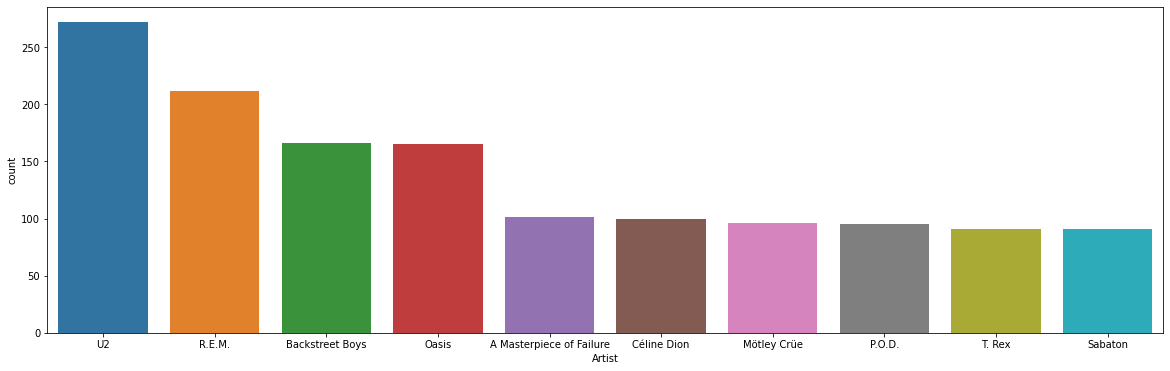

In [21]:
sns.countplot(x='Artist',data =song_lyrics_df, order=song_lyrics_df['Artist'].value_counts().index[0:10])
plt.show()

#### Artist with Least Number of Songs

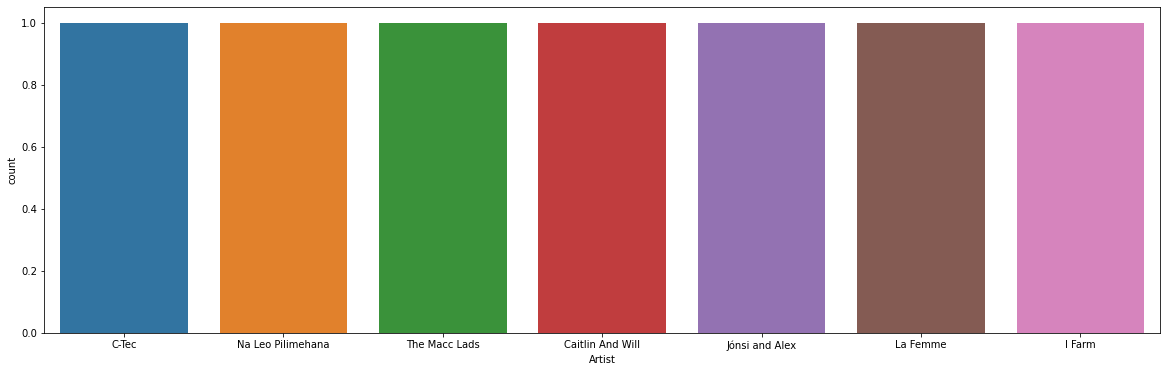

In [22]:
sns.countplot(x='Artist',data =song_lyrics_df, order=song_lyrics_df['Artist'].value_counts().index[-8:-1])
plt.show()

#### Artist with Highest & Least length of Words

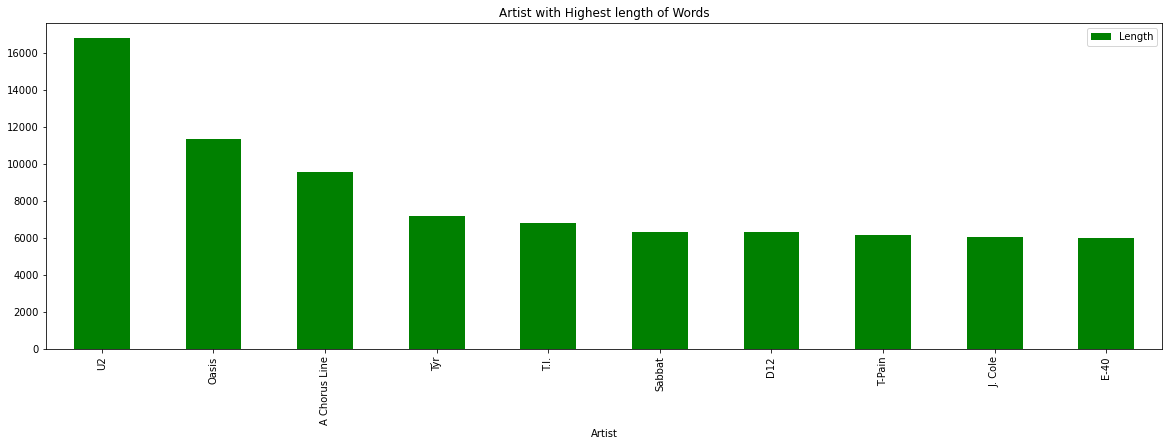

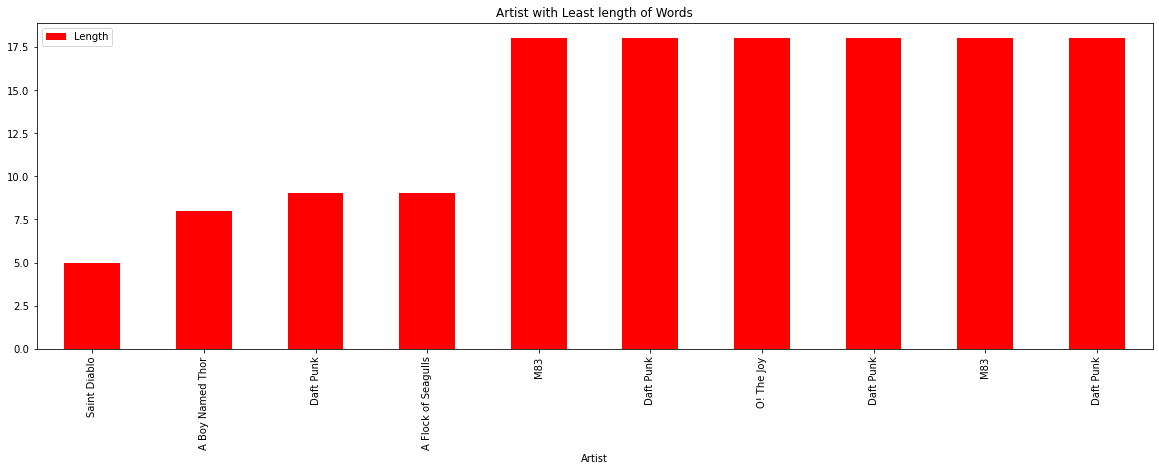

In [23]:
song_lyrics_df.iloc[:,[1,2,4]].sort_values('Length', ascending = False, inplace = False).head(10).plot.bar(x='Artist', y='Length',color='green',title=('Artist with Highest length of Words'))
song_lyrics_df.iloc[:,[1,2,4]].sort_values('Length', ascending = True, inplace = False).head(10).plot.bar(x='Artist', y='Length',color='red',title=('Artist with Least length of Words'))
plt.show()

#### Distribution of Character Length for Lyrics

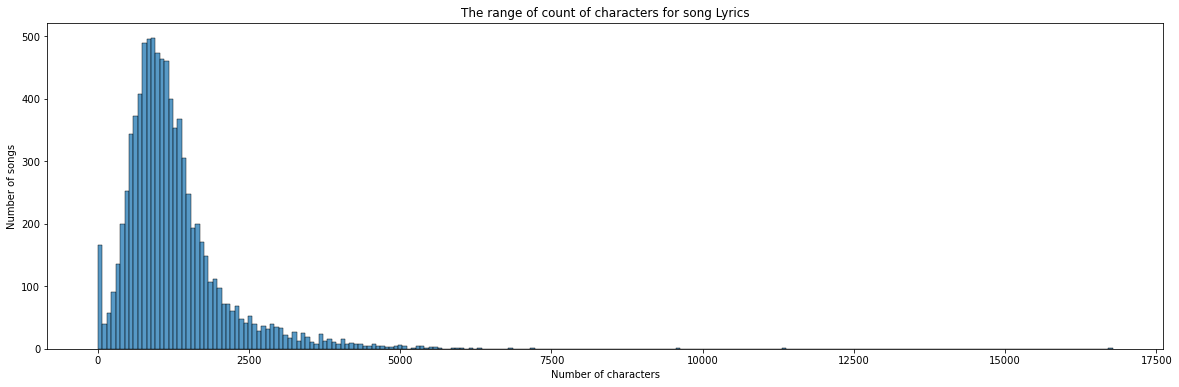

In [24]:
sns.histplot(song_lyrics_df['Length'])
plt.xlabel('Number of characters')
plt.title('The range of count of characters for song Lyrics')
plt.ylabel('Number of songs')
plt.show()

#### Analysing for 400 to 1000 characters:

In [25]:
def remove_linebreak(raw_str):
    out = str(raw_str).replace('\n','').replace('\r','')
    return out

In [26]:
song_lyrics_df[(song_lyrics_df['Length']>400) & 
                                (song_lyrics_df['Length']<=1000)]['Lyrics'].sample(4, random_state = 0)

1551    The ring like a stain in the wood \r\nA drink ...
114     But we still shine \r\nWalk the line, waiting ...
2281    Why don't you break the MIRROR?  \r\nJust what...
8105    Judith \r\nJudith, can you hear me \r\nCan you...
Name: Lyrics, dtype: object

In [27]:
#for lyrics in song_lyrics_df[(song_lyrics_df['Length']>400) & 
                                #(song_lyrics_df['Length']<=1000)]['Lyrics'].sample(4, random_state = 0):
    #print(remove_linebreak(lyrics)+'\n')
    
song_lyrics_df.iloc[:,[1,2,4]][(song_lyrics_df['Length']>400) & 
                                (song_lyrics_df['Length']<=1000)].sort_values('Length', ascending = False, inplace = False).head()

,Artist,Song,Length
7091,Sade,Clean Heart,1000
3919,J.R.R. Tolkien,I Sit Beside the Fire and Think,1000
1237,Babyshambles,I Wish,1000
4071,k-os,Superstarr Pt. 1,1000
8591,"10,000 Maniacs",City Of Angels,1000


In [28]:
len(song_lyrics_df.iloc[:,[1,2,4]][(song_lyrics_df['Length']>400) & 
                                (song_lyrics_df['Length']<=1000)])

3300

#### Analysing for 1000 to 1400 characters:

In [29]:
song_lyrics_df[(song_lyrics_df['Length']>1000) & 
                                (song_lyrics_df['Length']<=1400)]['Lyrics'].sample(4, random_state = 0)

4410    Cocaína, cocaína, ya me voy para Bolivia.  \nC...
1794    Call on me, oh call up, baby. \nCall on me, oh...
4976    Jack in, let's spread some hate \r\nHand out o...
3496    Hey little girl with the cash to burn  \r\nWel...
Name: Lyrics, dtype: object

In [30]:
#for lyrics in song_lyrics_df[(song_lyrics_df['Length']>1000) & 
 #                               (song_lyrics_df['Length']<=1400)]['Lyrics'].sample(4, random_state = 0):
   # print(remove_linebreak(lyrics)+'\n')
    
song_lyrics_df.iloc[:,[1,2,4]][(song_lyrics_df['Length']>1000) & 
                                (song_lyrics_df['Length']<=1400)].sort_values('Length', ascending = False, inplace = False).head()

,Artist,Song,Length
876,A Skylit Drive,Prelude To a Dream,1400
8437,The Waitresses,No Guilt,1400
7551,Sam Amidon,How Come That Blood,1399
8524,10 Years,Chasing The Rapture,1399
1885,Caedmon's Call,Piece of Glass,1399


In [31]:
len(song_lyrics_df.iloc[:,[1,2,4]][(song_lyrics_df['Length']>1000) & (song_lyrics_df['Length']<=1400)])

2252

### Comment Analysis

#### Artist reciving Highest Number of Comments

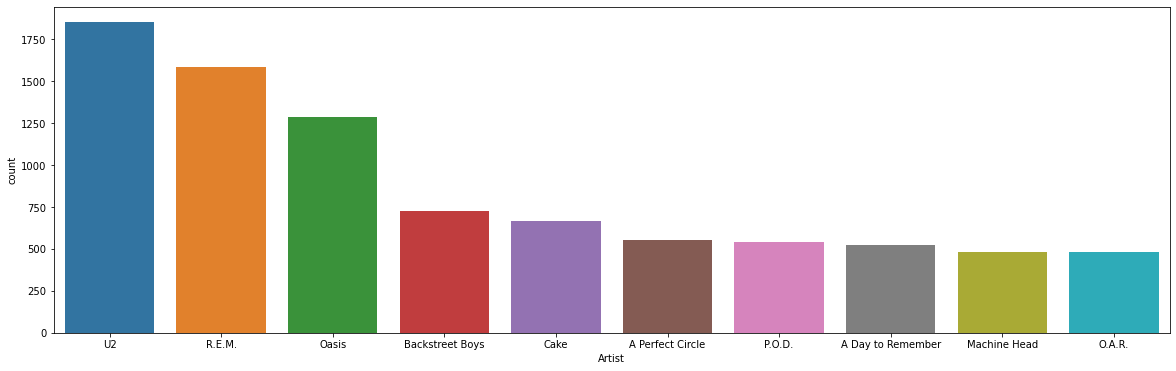

In [32]:
sns.countplot(x='Artist',data =song_comments_df, order=song_comments_df['Artist'].value_counts().index[0:10])
plt.show()

#### Artist reciving Least Number of Comments

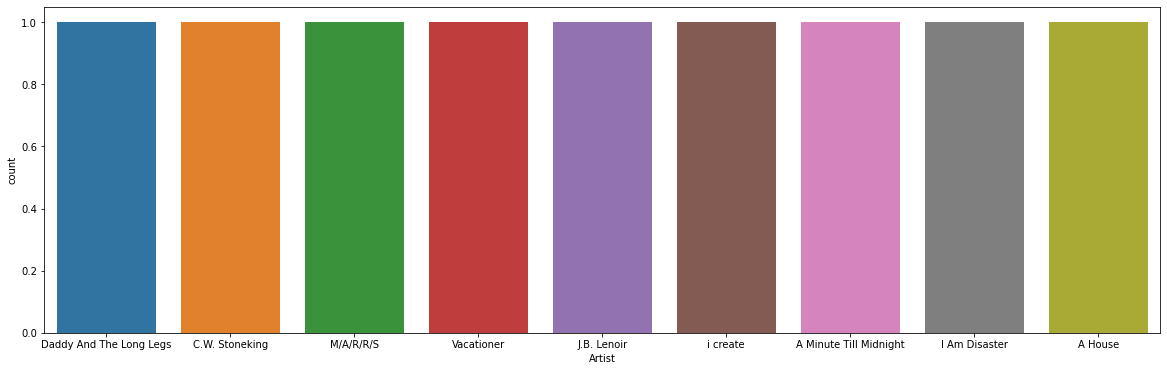

In [33]:
sns.countplot(x='Artist',data =song_comments_df, order=song_comments_df['Artist'].value_counts().index[-10:-1])
plt.show()

#### Distribution of Character Length for Comments

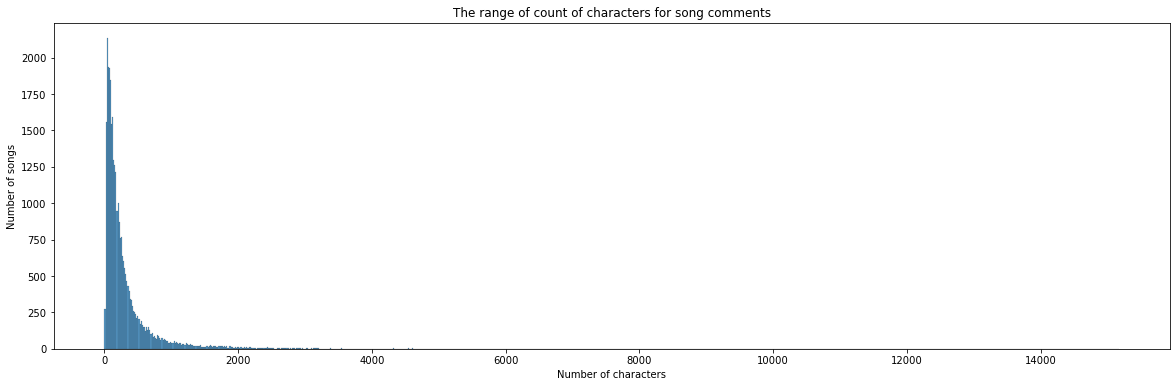

In [34]:
sns.histplot(song_comments_df['Length'])
plt.xlabel('Number of characters')
plt.title('The range of count of characters for song comments')
plt.ylabel('Number of songs')
plt.show()

#### Analysing for 100-400 characters:

In [35]:
song_comments_df[(song_comments_df['Length']>100) & 
                                (song_comments_df['Length']<=400)]['Comment'].sample(4, random_state = 42)

10134     This is just a simple song... \n \r\nHear it ...
7715      I like the part about Cinco de Mayo. When is ...
21698     lol cute, Waiting on Friday. I think its abou...
14624     Oh my gosh, Lari21, I very much agree with yo...
Name: Comment, dtype: object

In [36]:
#for comment in song_comments_df[(song_comments_df['Length']>100) & 
 #                               (song_comments_df['Length']<=400)]['Comment'].sample(4, random_state = 42):
    #print(remove_linebreak(comment)+'\n')

song_comments_df.iloc[:,[1,2,4]][(song_comments_df['Length']>100) & 
                                (song_comments_df['Length']<=400)].sort_values('Length', ascending = False, inplace = False).head()

,Artist,Song,Length
22785,R.E.M.,E-Bow The Letter,400
14110,L7,Can I Run,400
15977,M.I.A.,O... Saya,400
3204,A Skylit Drive,The Cali Buds,400
14899,Mötley Crüe,Don't Go Away Mad (Just Go Away),400


In [37]:
len(song_comments_df.iloc[:,[1,2,4]][(song_comments_df['Length']>100) &  (song_comments_df['Length']<=400)])

15299

#### Analysing for greater than 400 characters

In [38]:
song_comments_df[song_comments_df['Length']>400]['Comment'].sample(4, random_state = 7)

14218     This is just my stab at what the lyrics mean,...
19965     a fuck off song if ever i heard one. a bit li...
23954     It's amazing that the tow best love songs eve...
2644      Since I had a very similar experience, I can ...
Name: Comment, dtype: object

In [39]:
#for comment in song_comments_df[song_comments_df['Length']>400]['Comment'].sample(4, random_state = 7):
    #print(remove_linebreak(comment)+'\n')
    
song_comments_df.iloc[:,[1,2,4]][song_comments_df['Length']>100].sort_values('Length', ascending = False, inplace = False).head()

,Artist,Song,Length
14418,La Dispute,The Last Lost Continent,15167
29767,U2,Stand Up Comedy,12539
24031,RA,Rectifier,12329
25798,Sade,Kiss Of Life,10470
8886,Daft Punk,Get Lucky,10445


In [40]:
len(song_comments_df.iloc[:,[1,2,4]][song_comments_df['Length']>100])

21842

## 5. Data Pre-Processing

### Data Processing on Lyrics and Comments

In [41]:
song_lyrics_df_1=song_lyrics_df.copy()#making a copy of original dataframe
song_comments_df_1=song_comments_df.copy()#making a copy of original dataframe

### Lowercase

In [42]:
song_lyrics_df_1['Lyrics_tokens']=song_lyrics_df_1['Lyrics'].str.lower().str.replace('[^a-z\s]', '')
song_lyrics_df_1.head()

,ID,Artist,Song,Lyrics,Length,Lyrics_tokens
0,1,A,6 O'clock On A Tube Stop,"6 o'clock on a tube stop, waiting for a subway...",1201,oclock on a tube stop waiting for a subway tr...
1,2,A,8 Fingers,"One, I'm ready for two \r\nToo many, three, fo...",856,one im ready for two \r\ntoo many three four \...
2,3,A,Afterburner,"Afterburner, after burning out, \r\nThere's a ...",1437,afterburner after burning out \r\ntheres a new...
3,4,A,Bad Idea,Bad idea (x4) \n \r\nNinety-nine per cent is ...,576,bad idea x \n \r\nninetynine per cent is grea...
4,5,A,Better Off With Him,"Run around, \r\nWhat's the frequency you're on...",1797,run around \r\nwhats the frequency youre on \r...


In [43]:
song_comments_df_1['Comment_tokens']=song_comments_df_1['Comment'].str.lower().str.replace('[^a-z\s]', '')
song_comments_df_1.head()

,ID,Artist,Song,Comment,Length,Comment_tokens
0,1,A,6 O'clock On A Tube Stop,"""There a bomb in a sports bag, could go off a...",95,there a bomb in a sports bag could go off at ...
1,2,A,8 Fingers,\n \n \r\nI think this site hasn't been coded...,60,\n \n \r\ni think this site hasnt been coded ...
2,2,A,8 Fingers,"ok, it has :) no message to the admin then\n ...",52,ok it has no message to the admin then\n \n ...
3,3,A,Afterburner,why no comments on this song? it kicks ass! i...,153,why no comments on this song it kicks ass i t...
4,3,A,Afterburner,"I'm pretty sure he sings: ""There's a news ale...",320,im pretty sure he sings theres a news alert i...


### Tokenization

In [44]:
tokenizer = RegexpTokenizer(r'\w+') 
song_lyrics_df_1['Lyrics_tokens']=song_lyrics_df_1['Lyrics_tokens'].apply(tokenizer.tokenize)
song_lyrics_df_1.head()

,ID,Artist,Song,Lyrics,Length,Lyrics_tokens
0,1,A,6 O'clock On A Tube Stop,"6 o'clock on a tube stop, waiting for a subway...",1201,"[oclock, on, a, tube, stop, waiting, for, a, s..."
1,2,A,8 Fingers,"One, I'm ready for two \r\nToo many, three, fo...",856,"[one, im, ready, for, two, too, many, three, f..."
2,3,A,Afterburner,"Afterburner, after burning out, \r\nThere's a ...",1437,"[afterburner, after, burning, out, theres, a, ..."
3,4,A,Bad Idea,Bad idea (x4) \n \r\nNinety-nine per cent is ...,576,"[bad, idea, x, ninetynine, per, cent, is, grea..."
4,5,A,Better Off With Him,"Run around, \r\nWhat's the frequency you're on...",1797,"[run, around, whats, the, frequency, youre, on..."


In [45]:
tokenizer = RegexpTokenizer(r'\w+') 
song_comments_df_1['Comment_tokens']=song_comments_df_1['Comment_tokens'].apply(tokenizer.tokenize)
song_comments_df_1.head()

,ID,Artist,Song,Comment,Length,Comment_tokens
0,1,A,6 O'clock On A Tube Stop,"""There a bomb in a sports bag, could go off a...",95,"[there, a, bomb, in, a, sports, bag, could, go..."
1,2,A,8 Fingers,\n \n \r\nI think this site hasn't been coded...,60,"[i, think, this, site, hasnt, been, coded, pro..."
2,2,A,8 Fingers,"ok, it has :) no message to the admin then\n ...",52,"[ok, it, has, no, message, to, the, admin, then]"
3,3,A,Afterburner,why no comments on this song? it kicks ass! i...,153,"[why, no, comments, on, this, song, it, kicks,..."
4,3,A,Afterburner,"I'm pretty sure he sings: ""There's a news ale...",320,"[im, pretty, sure, he, sings, theres, a, news,..."


## Lemmatization

In [46]:
#import nltk
#nltk.download('wordnet')

In [47]:
Lemmatizer = WordNetLemmatizer()

In [48]:
def lemmatize(text): 
    return [Lemmatizer.lemmatize(word) for word in text]

In [49]:
song_lyrics_df_1['Lyrics_tokens']=song_lyrics_df_1['Lyrics_tokens'].apply(lemmatize)
song_lyrics_df_1.head()

,ID,Artist,Song,Lyrics,Length,Lyrics_tokens
0,1,A,6 O'clock On A Tube Stop,"6 o'clock on a tube stop, waiting for a subway...",1201,"[oclock, on, a, tube, stop, waiting, for, a, s..."
1,2,A,8 Fingers,"One, I'm ready for two \r\nToo many, three, fo...",856,"[one, im, ready, for, two, too, many, three, f..."
2,3,A,Afterburner,"Afterburner, after burning out, \r\nThere's a ...",1437,"[afterburner, after, burning, out, there, a, n..."
3,4,A,Bad Idea,Bad idea (x4) \n \r\nNinety-nine per cent is ...,576,"[bad, idea, x, ninetynine, per, cent, is, grea..."
4,5,A,Better Off With Him,"Run around, \r\nWhat's the frequency you're on...",1797,"[run, around, whats, the, frequency, youre, on..."


In [50]:
song_comments_df_1['Comment_tokens']=song_comments_df_1['Comment_tokens'].apply(lemmatize)
song_comments_df_1.head()

,ID,Artist,Song,Comment,Length,Comment_tokens
0,1,A,6 O'clock On A Tube Stop,"""There a bomb in a sports bag, could go off a...",95,"[there, a, bomb, in, a, sport, bag, could, go,..."
1,2,A,8 Fingers,\n \n \r\nI think this site hasn't been coded...,60,"[i, think, this, site, hasnt, been, coded, pro..."
2,2,A,8 Fingers,"ok, it has :) no message to the admin then\n ...",52,"[ok, it, ha, no, message, to, the, admin, then]"
3,3,A,Afterburner,why no comments on this song? it kicks ass! i...,153,"[why, no, comment, on, this, song, it, kick, a..."
4,3,A,Afterburner,"I'm pretty sure he sings: ""There's a news ale...",320,"[im, pretty, sure, he, sings, there, a, news, ..."


### Stopwords

In [51]:
common_stopwords = nltk.corpus.stopwords.words('english')
common_stopwords.extend(["i'm",'I','lyric','song','band','album','instrumental','think','person','people','someone','really','know',
                       'like','want','feel','dont','great','wa','one','ha','oh','yeah','hey','never','say','ooh','get',
                       'got','u','heard','gonna','wanna','thing','could','let','go','meaning','chorus','would','something',
                         'thought','would','still','something','around','little','nothing','everything','Fuck Tha Police','always','better',
                          'cause','still','going','gotta','maybe','going','everyone','everybody','anyone','anybody','anything',
                         'interpretation','comment','stuff','sound','thats','others','forget', 'place', 'moment', 'music',
                          'matter', 'comment', 'verse', 'version', 'sound', 'track', 'interpretation', 'guess', 'reminds', 
                          'singer','cd','lot','way','ah','line','part','day','word','doe','x4','opinion','relate','doesnt','lol','listen','haha',
                        'amp','rt',';',':','!','?','/','\\',',','#','@','$','&',')','(','\''])
len(common_stopwords)

294

In [52]:
def dropstop_words(text): 
    return [word for word in text if word not in common_stopwords]

In [53]:
song_lyrics_df_1['Lyrics_tokens']=song_lyrics_df_1['Lyrics_tokens'].apply(dropstop_words)
song_lyrics_df_1.head()

,ID,Artist,Song,Lyrics,Length,Lyrics_tokens
0,1,A,6 O'clock On A Tube Stop,"6 o'clock on a tube stop, waiting for a subway...",1201,"[oclock, tube, stop, waiting, subway, train, a..."
1,2,A,8 Fingers,"One, I'm ready for two \r\nToo many, three, fo...",856,"[im, ready, two, many, three, four, im, count,..."
2,3,A,Afterburner,"Afterburner, after burning out, \r\nThere's a ...",1437,"[afterburner, burning, news, alert, poor, kid,..."
3,4,A,Bad Idea,Bad idea (x4) \n \r\nNinety-nine per cent is ...,576,"[bad, idea, x, ninetynine, per, cent, percent,..."
4,5,A,Better Off With Him,"Run around, \r\nWhat's the frequency you're on...",1797,"[run, whats, frequency, youre, addiction, youl..."


In [54]:
song_comments_df_1['Comment_tokens']=song_comments_df_1['Comment_tokens'].apply(dropstop_words)
song_comments_df_1.head()

,ID,Artist,Song,Comment,Length,Comment_tokens
0,1,A,6 O'clock On A Tube Stop,"""There a bomb in a sports bag, could go off a...",95,"[bomb, sport, bag, time, kinda, relevant, eh]"
1,2,A,8 Fingers,\n \n \r\nI think this site hasn't been coded...,60,"[site, hasnt, coded, properly]"
2,2,A,8 Fingers,"ok, it has :) no message to the admin then\n ...",52,"[ok, message, admin]"
3,3,A,Afterburner,why no comments on this song? it kicks ass! i...,153,"[kick, relationship, basically, trouble, getting]"
4,3,A,Afterburner,"I'm pretty sure he sings: ""There's a news ale...",320,"[im, pretty, sure, sings, news, alert, aid, ku..."


## 6. Bag of words analysis

### Lyrics

In [55]:
# Lyrics Analysis

docs_lyrics = song_lyrics_df_1['Lyrics_tokens']
print(docs_lyrics.head(),'\n')

tokens_lyrics = []
for tokensl in docs_lyrics:
    tokens_lyrics.extend(tokensl)
print('No. of tokens in entire corpus of Lyrics:', len(tokens_lyrics),'\n')

0    [oclock, tube, stop, waiting, subway, train, a...
1    [im, ready, two, many, three, four, im, count,...
2    [afterburner, burning, news, alert, poor, kid,...
3    [bad, idea, x, ninetynine, per, cent, percent,...
4    [run, whats, frequency, youre, addiction, youl...
Name: Lyrics_tokens, dtype: object 

No. of tokens in entire corpus of Lyrics: 878670 



In [56]:
# Lyrics
lyrics_freq = pd.Series(tokens_lyrics).value_counts()
print(lyrics_freq,'\n')

im              17401
love             9595
time             7418
youre            6803
see              6580
                ...  
forgivin            1
gewhlt              1
somethingbut        1
offa                1
deliberately        1
Length: 43858, dtype: int64 



Frequency Tokens based on Lyrics



,token,frequency
0,im,17401
1,love,9595
2,time,7418
3,youre,6803
4,see,6580


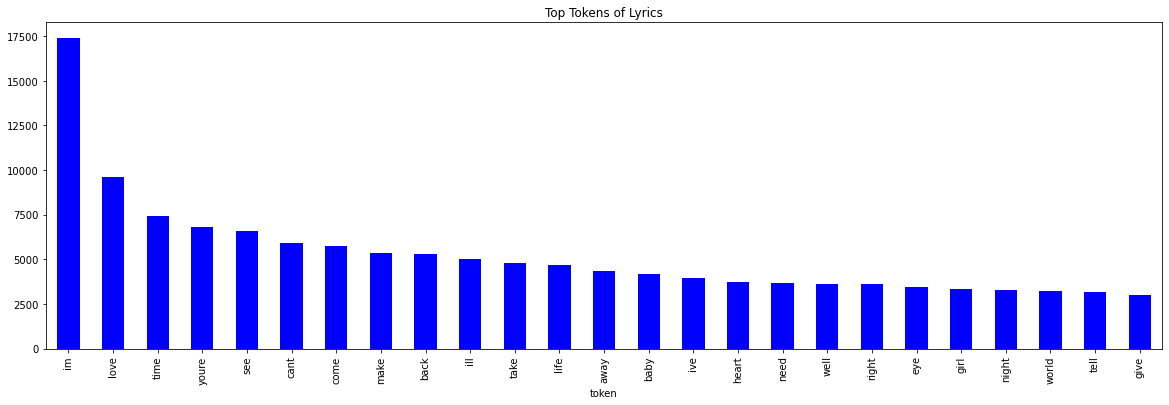

In [57]:
# frequency of Tokens of Lyrics
print("Frequency Tokens based on Lyrics")
print()
lyrics_tokens = pd.DataFrame(lyrics_freq).reset_index().rename(columns={'index': 'token', 0: 'frequency'})
lyrics_tokens = lyrics_tokens[~lyrics_tokens['token'].isin(common_stopwords)]
lyrics_tokens.set_index('token')['frequency'].head(25).plot.bar(color='blue',title=('Top Tokens of Lyrics'))
lyrics_tokens.head(5)

### Comments

In [58]:
# Comments Analysis

docs_comments = song_comments_df_1['Comment_tokens']
print(docs_comments.head(),'\n')

tokens_comments = []
for tokensc in docs_comments:
    tokens_comments.extend(tokensc)
print('No. of tokens in entire corpus of Comments:', len(tokens_comments),'\n')

0        [bomb, sport, bag, time, kinda, relevant, eh]
1                       [site, hasnt, coded, properly]
2                                 [ok, message, admin]
3    [kick, relationship, basically, trouble, getting]
4    [im, pretty, sure, sings, news, alert, aid, ku...
Name: Comment_tokens, dtype: object 

No. of tokens in entire corpus of Comments: 674991 



In [59]:
#Comments
Comments_freq = pd.Series(tokens_comments).value_counts()
print(Comments_freq,'\n')

love                10170
im                   5370
time                 4996
life                 4521
make                 4235
                    ...  
croydon                 1
reminderswanting        1
begn                    1
sneeking                1
ripoffs                 1
Length: 46036, dtype: int64 



Frequency Tokens based on Comments



,token,frequency
0,love,10170
1,im,5370
2,time,4996
3,life,4521
4,make,4235


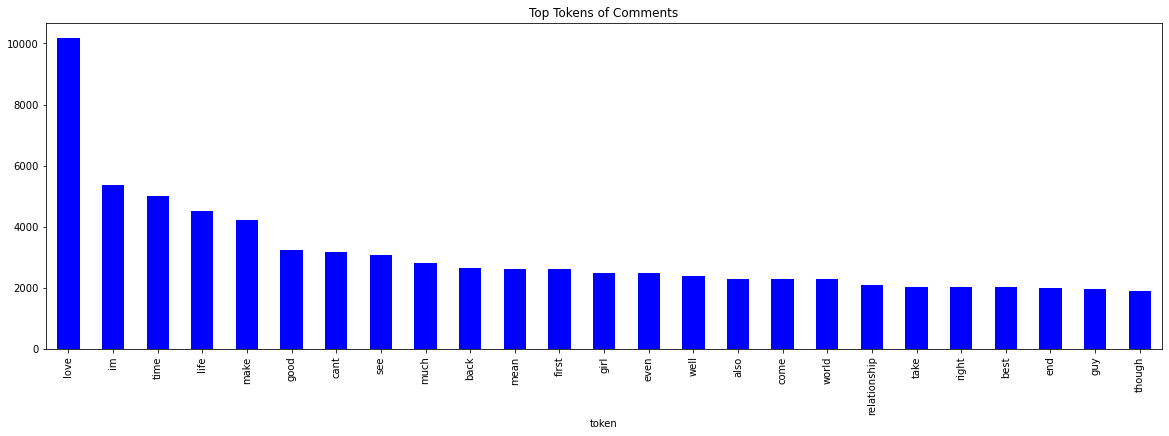

In [60]:
# frequency of Tokens of Comments
print("Frequency Tokens based on Comments")
print()
Comments_tokens = pd.DataFrame(Comments_freq).reset_index().rename(columns={'index': 'token', 0: 'frequency'})
Comments_tokens = Comments_tokens[~Comments_tokens['token'].isin(common_stopwords)]
Comments_tokens.set_index('token')['frequency'].head(25).plot.bar(color='blue',title=('Top Tokens of Comments'))
Comments_tokens.head()

# 7. Sentiment Analysis using Rule Based Algorithm

In [61]:
#import nltk
#nltk.download('vader_lexicon')

In [62]:
analyzer = SentimentIntensityAnalyzer()

### Sentiment analysis on Lyrics

In [63]:
# Analyzing Semtiment on Lyrics
song_lyrics_df_1['Lyrics_sentiment_vader'] = song_lyrics_df_1['Lyrics'].apply(lambda v: analyzer.polarity_scores(v)['compound'])
song_lyrics_df_1.head(10)

,ID,Artist,Song,Lyrics,Length,Lyrics_tokens,Lyrics_sentiment_vader
0,1,A,6 O'clock On A Tube Stop,"6 o'clock on a tube stop, waiting for a subway...",1201,"[oclock, tube, stop, waiting, subway, train, a...",-0.9247
1,2,A,8 Fingers,"One, I'm ready for two \r\nToo many, three, fo...",856,"[im, ready, two, many, three, four, im, count,...",0.9640
2,3,A,Afterburner,"Afterburner, after burning out, \r\nThere's a ...",1437,"[afterburner, burning, news, alert, poor, kid,...",0.8267
3,4,A,Bad Idea,Bad idea (x4) \n \r\nNinety-nine per cent is ...,576,"[bad, idea, x, ninetynine, per, cent, percent,...",-0.9681
4,5,A,Better Off With Him,"Run around, \r\nWhat's the frequency you're on...",1797,"[run, whats, frequency, youre, addiction, youl...",0.9977
5,6,A,Going Down,"Suck it up, we're going down \r\n30 seconds 't...",1290,"[suck, second, till, smash, ground, passenger,...",0.8281
6,7,A,I Love Lake Tahoe,4 long years ago \r\nSearching for the snow \r...,613,"[long, year, ago, searching, snow, found, taho...",0.7579
7,8,A,"If It Ain't Broke, Fix It Anyway","Coming back at you, record number two \r\nWhat...",1038,"[coming, back, record, number, two, start, you...",0.9625
8,9,A,Jason's Addiction,Pretty scary how they know you \r\nIt depends ...,766,"[pretty, scary, depends, talk, end, beginning,...",0.9501
9,10,A,Long Distance,Long distance last goodbye \r\ncan't give it ...,997,"[long, distance, last, goodbye, cant, give, la...",0.8902


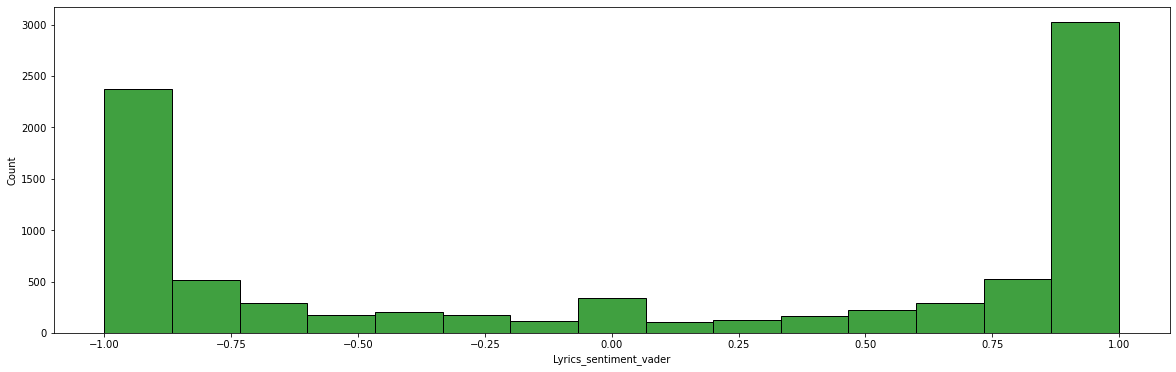

In [64]:
sns.histplot(song_lyrics_df_1['Lyrics_sentiment_vader'],color='g')
plt.show()

### 10 most Positive Songs & Artists based on Lyrics

In [65]:
song_lyrics_df_1.iloc[:,[1,2,6]].sort_values('Lyrics_sentiment_vader', ascending = False, inplace = False).head(10)

,Artist,Song,Lyrics_sentiment_vader
2527,Daft Punk,High Fidelity,0.9999
4429,La Roux,Paradise Is You,0.9999
4275,La Bouche,Another night another dream,0.9999
8173,U2,Stand Up Comedy,0.9998
7049,Sabrina Carpenter,Almost Love,0.9998
5433,N.E.R.D.,Backseat Love,0.9998
6243,R. Kelly,Step In The Name Of Love,0.9998
8071,U2,Hawkmoon 269,0.9998
2537,Daft Punk,One More Time,0.9998
7626,T-Pain,I'm N Luv (Wit a Stripper) (Remix),0.9998


### 10 most Negative Songs & Artists based on Lyrics

In [66]:
song_lyrics_df_1.iloc[:,[1,2,6]].sort_values('Lyrics_sentiment_vader', ascending = True, inplace = False).head(10)

,Artist,Song,Lyrics_sentiment_vader
5484,N.W.A.,Fuck Tha Police,-0.9999
2626,E-40,Dusted N' Disgusted,-0.9999
2435,D12,Shit On You,-0.9998
3946,Ja Rule,So Much Pain,-0.9998
2416,D12,Devils Night,-0.9998
412,A Heartwell Ending,If Looks Could Kill,-0.9998
2334,D.O.A.,Full Metal Jackoff,-0.9998
5489,N.W.A.,Just Don't Bite It,-0.9998
7222,Sage Francis,Conspiracy To Riot,-0.9997
2437,D12,Thats How,-0.9997


### Sentiment analysis on Comments

In [67]:
# Analyzing Semtiment on Comments
song_comments_df_1['Comment_sentiment_vader'] = song_comments_df_1['Comment'].apply(lambda v: analyzer.polarity_scores(v)['compound'])
song_comments_df_1.head(10)

,ID,Artist,Song,Comment,Length,Comment_tokens,Comment_sentiment_vader
0,1,A,6 O'clock On A Tube Stop,"""There a bomb in a sports bag, could go off a...",95,"[bomb, sport, bag, time, kinda, relevant, eh]",-0.4939
1,2,A,8 Fingers,\n \n \r\nI think this site hasn't been coded...,60,"[site, hasnt, coded, properly]",0.0000
2,2,A,8 Fingers,"ok, it has :) no message to the admin then\n ...",52,"[ok, message, admin]",0.4588
3,3,A,Afterburner,why no comments on this song? it kicks ass! i...,153,"[kick, relationship, basically, trouble, getting]",-0.8268
4,3,A,Afterburner,"I'm pretty sure he sings: ""There's a news ale...",320,"[im, pretty, sure, sings, news, alert, aid, ku...",0.8520
5,4,A,Bad Idea,'good idea' and the aussie remix of 'bad idea...,88,"[good, idea, aussie, remix, bad, idea, wicked,...",-0.5648
6,4,A,Bad Idea,Steve Lamacq's song of 1997/98...it's easy to...,353,"[steve, lamacqs, easy, understand, grumpy, jas...",0.7424
7,5,A,Better Off With Him,wtf? how does this song have no comments :S\n...,53,[wtf],-0.8374
8,6,A,Going Down,I was amazed by the content of this when i fi...,328,"[amazed, content, first, read, book, hifi, ser...",0.8718
9,6,A,Going Down,Brain_case's spot on. It's a chilling little ...,90,"[braincase, spot, chilling, number, time]",0.7358


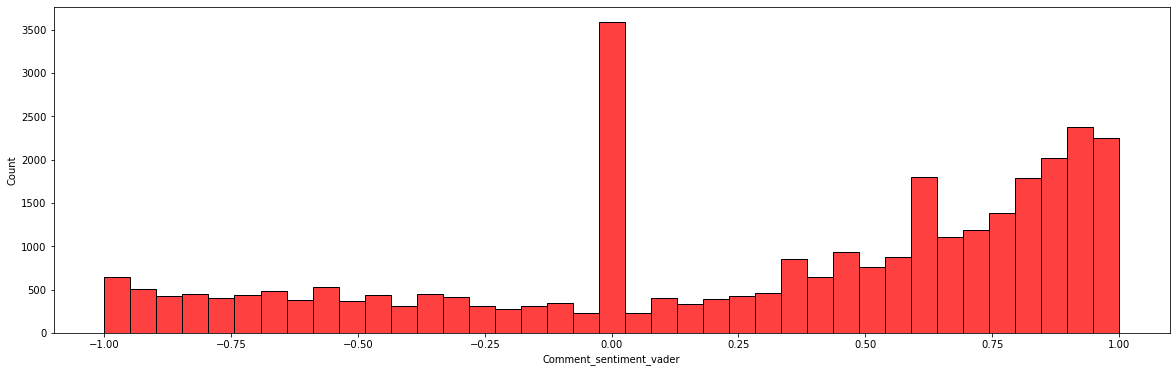

In [68]:
sns.histplot(song_comments_df_1['Comment_sentiment_vader'],color='r')
plt.show()

### 10 most Positive Comments

In [69]:
song_comments_df_1.iloc[:,[1,2,6]].sort_values('Comment_sentiment_vader', ascending = False, inplace = False).head(10)

,Artist,Song,Comment_sentiment_vader
25798,Sade,Kiss Of Life,0.9999
8886,Daft Punk,Get Lucky,0.9999
29767,U2,Stand Up Comedy,0.9999
1227,A Fine Frenzy,Near To You,0.9995
29186,U2,In God's Country,0.9995
21380,P.O.D.,Guitarras De Amor,0.9995
14418,La Dispute,The Last Lost Continent,0.9995
22766,R.E.M.,Driver 8,0.9994
26089,Saez,So Gorgeous,0.9994
6966,Cage,Astrology,0.9993


### 10 most Negative Comments

In [70]:
song_comments_df_1.iloc[:,[1,2,6]].sort_values('Comment_sentiment_vader', ascending = True, inplace = False).head(10)

,Artist,Song,Comment_sentiment_vader
26793,SALEM (USA),Sick,-0.9997
9998,Earl Sweatshirt,Drop,-0.9996
26810,SALEM (USA),tent,-0.9994
9996,Earl Sweatshirt,Couch,-0.9993
20197,Oasis,Don't Look Back in Anger,-0.9992
31337,10 Years,The Wicked Ones,-0.9991
14219,La Dispute,A Broken Jar,-0.9991
30234,U2,Winter,-0.9988
26797,SALEM (USA),Sick,-0.9988
5713,Bad Astronaut,Greg's Estate,-0.9988


# 8. Word Cloud Analysis

### Checking the Emotions of Lyrics

In [71]:
def get_sentiment_label(compound_score):
    if compound_score > 0.3:
        return 'positive'
    elif compound_score < -0.3:
        return 'negative'
    else:
        return 'neutral'

# Conditional count of Positive and Negative Sentiment of Lyrics
song_lyrics_df_1['Lyrics_sentiment_pred_label'] = song_lyrics_df_1['Lyrics_sentiment_vader'].apply(get_sentiment_label)
print('Lyrics Sentiment Analysis')
print(song_lyrics_df_1['Lyrics_sentiment_pred_label'].value_counts(),'\n')

# Conditional count of Positive and Negative Sentiment of Comments
song_comments_df_1['Comments_sentiment_pred_label'] = song_comments_df_1['Comment_sentiment_vader'].apply(get_sentiment_label)
print('Comments Sentiment Analysis')
print(song_comments_df_1['Comments_sentiment_pred_label'].value_counts(),'\n')

Lyrics Sentiment Analysis
positive    4258
negative    3594
neutral      797
Name: Lyrics_sentiment_pred_label, dtype: int64 

Comments Sentiment Analysis
positive    18250
neutral      7244
negative     6027
Name: Comments_sentiment_pred_label, dtype: int64 



In [72]:
song_lyrics_df_1.head()#checking fot new column

,ID,Artist,Song,Lyrics,Length,Lyrics_tokens,Lyrics_sentiment_vader,Lyrics_sentiment_pred_label
0,1,A,6 O'clock On A Tube Stop,"6 o'clock on a tube stop, waiting for a subway...",1201,"[oclock, tube, stop, waiting, subway, train, a...",-0.9247,negative
1,2,A,8 Fingers,"One, I'm ready for two \r\nToo many, three, fo...",856,"[im, ready, two, many, three, four, im, count,...",0.9640,positive
2,3,A,Afterburner,"Afterburner, after burning out, \r\nThere's a ...",1437,"[afterburner, burning, news, alert, poor, kid,...",0.8267,positive
3,4,A,Bad Idea,Bad idea (x4) \n \r\nNinety-nine per cent is ...,576,"[bad, idea, x, ninetynine, per, cent, percent,...",-0.9681,negative
4,5,A,Better Off With Him,"Run around, \r\nWhat's the frequency you're on...",1797,"[run, whats, frequency, youre, addiction, youl...",0.9977,positive


In [73]:
song_comments_df_1.head()#checking fot new column

,ID,Artist,Song,Comment,Length,Comment_tokens,Comment_sentiment_vader,Comments_sentiment_pred_label
0,1,A,6 O'clock On A Tube Stop,"""There a bomb in a sports bag, could go off a...",95,"[bomb, sport, bag, time, kinda, relevant, eh]",-0.4939,negative
1,2,A,8 Fingers,\n \n \r\nI think this site hasn't been coded...,60,"[site, hasnt, coded, properly]",0.0000,neutral
2,2,A,8 Fingers,"ok, it has :) no message to the admin then\n ...",52,"[ok, message, admin]",0.4588,positive
3,3,A,Afterburner,why no comments on this song? it kicks ass! i...,153,"[kick, relationship, basically, trouble, getting]",-0.8268,negative
4,3,A,Afterburner,"I'm pretty sure he sings: ""There's a news ale...",320,"[im, pretty, sure, sings, news, alert, aid, ku...",0.8520,positive


### Analyzing for different Emotions of Lyrics

,Artist,Song,Lyrics_sentiment_vader
4429,La Roux,Paradise Is You,0.9999
2527,Daft Punk,High Fidelity,0.9999
4275,La Bouche,Another night another dream,0.9999
140,A Cursive Memory,Pretty Little Thing,0.9998
8173,U2,Stand Up Comedy,0.9998


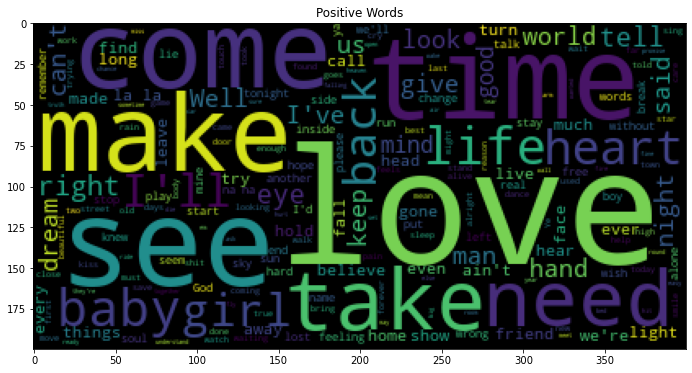

In [74]:
# Positive lyrics
lyric_text1 = song_lyrics_df_1[song_lyrics_df_1['Lyrics_sentiment_vader'] > 0.3]['Lyrics'].fillna('Not available')
docs_string_lyrics1 = ' '.join(lyric_text1)
wc_lyric1 = WordCloud(background_color='black', stopwords=common_stopwords).generate(docs_string_lyrics1)
plt.imshow(wc_lyric1)
plt.title('Positive Words')
song_lyrics_df_1.iloc[:,[1,2,6]][song_lyrics_df_1['Lyrics_sentiment_vader'] > 0.3].sort_values('Lyrics_sentiment_vader', ascending = False, inplace = False).head()

,Artist,Song,Lyrics_sentiment_vader
6597,Rachael Cantu,Your Hips Are Bad,0.2976
1443,Backstreet Boys,Missing You,0.2971
3375,H2O,Sacred Heart,0.2964
1804,Cadence Weapon,In Search Of The Youth Crew,0.2961
4366,La Ley,The Corridor,0.2960


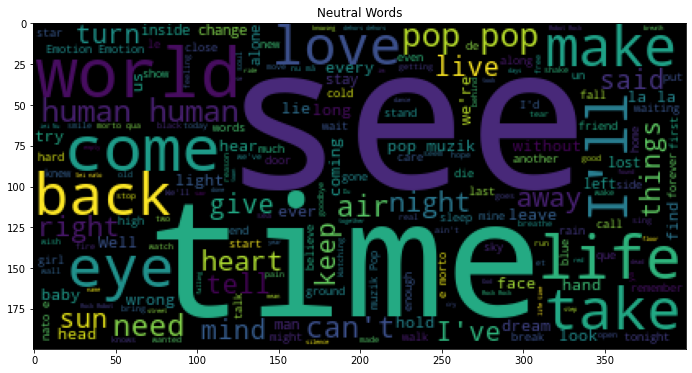

In [75]:
# Neutral Lyrics

lyric_text4 = song_lyrics_df_1[(song_lyrics_df_1['Lyrics_sentiment_vader'] < 0.3) & (song_lyrics_df_1['Lyrics_sentiment_vader'] > -0.3)]['Lyrics'].fillna('Not available')
docs_string_lyrics4 = ' '.join(lyric_text4)
wc_lyric4 = WordCloud(background_color='black', stopwords=common_stopwords).generate(docs_string_lyrics4)
plt.imshow(wc_lyric4)
plt.title('Neutral Words')

song_lyrics_df_1.iloc[:,[1,2,6]][(song_lyrics_df_1['Lyrics_sentiment_vader'] < 0.3) & (song_lyrics_df_1['Lyrics_sentiment_vader'] > -0.3)].sort_values('Lyrics_sentiment_vader', ascending = False, inplace = False).head()

,Artist,Song,Lyrics_sentiment_vader
2626,E-40,Dusted N' Disgusted,-0.9999
5484,N.W.A.,Fuck Tha Police,-0.9999
412,A Heartwell Ending,If Looks Could Kill,-0.9998
2435,D12,Shit On You,-0.9998
2334,D.O.A.,Full Metal Jackoff,-0.9998


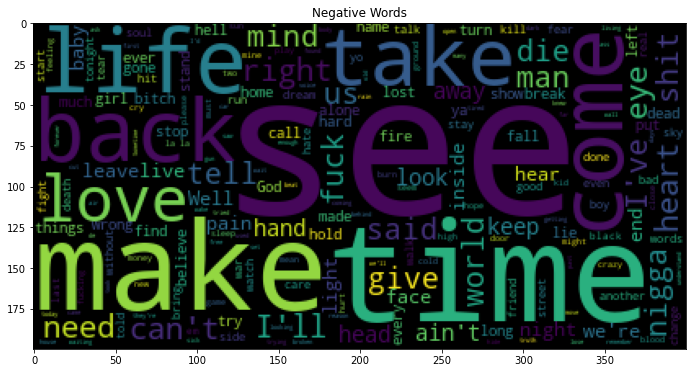

In [76]:
# Negative Lyrics

lyric_text7 = song_lyrics_df_1[song_lyrics_df_1['Lyrics_sentiment_vader'] < -0.3]['Lyrics'].fillna('Not available')
docs_string_lyrics7 = ' '.join(lyric_text7)
wc_lyric7 = WordCloud(background_color='black', stopwords=common_stopwords).generate(docs_string_lyrics7)
plt.imshow(wc_lyric7)
plt.title('Negative Words')

song_lyrics_df_1.iloc[:,[1,2,6]][song_lyrics_df_1['Lyrics_sentiment_vader'] < -0.3].sort_values('Lyrics_sentiment_vader', ascending = True, inplace = False).head()

### Analyzing for different Emotions of Comments

,Artist,Song,Comment_sentiment_vader
29767,U2,Stand Up Comedy,0.9999
8886,Daft Punk,Get Lucky,0.9999
25798,Sade,Kiss Of Life,0.9999
14418,La Dispute,The Last Lost Continent,0.9995
29186,U2,In God's Country,0.9995


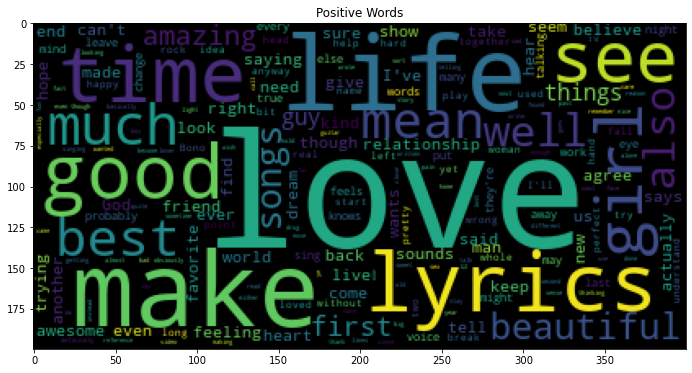

In [77]:
# Positive Comments
Comments_text1 = song_comments_df_1[song_comments_df_1['Comment_sentiment_vader'] > 0.3]['Comment'].fillna('Not available')
docs_string_comments1 = ' '.join(Comments_text1)
wc_comments1 = WordCloud(background_color='black', stopwords=common_stopwords).generate(docs_string_comments1)
plt.imshow(wc_comments1)
plt.title('Positive Words')
song_comments_df_1.iloc[:,[1,2,6]][song_comments_df_1['Comment_sentiment_vader'] > 0.3].sort_values('Comment_sentiment_vader', ascending = False, inplace = False).head()

,Artist,Song,Comment_sentiment_vader
15628,M. Ward,Right In The Head,0.2998
3175,A Skylit Drive,Pursuit Lets Wisdom Ride the Wind,0.2998
15728,M.I.A.,20 Dollar,0.2997
26469,Sage Francis,Slow Down Gandhi,0.2996
23940,R.E.M.,You Are The Everything,0.2994


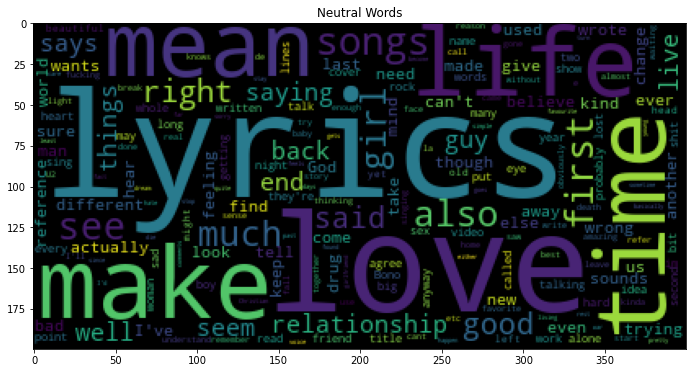

In [78]:
# Neutral Comments

Comments_text2 = song_comments_df_1[(song_comments_df_1['Comment_sentiment_vader'] < 0.3) & (song_comments_df_1['Comment_sentiment_vader'] > -0.3)]['Comment'].fillna('Not available')
docs_string_comments2 = ' '.join(Comments_text2)
wc_comments2 = WordCloud(background_color='black', stopwords=common_stopwords).generate(docs_string_comments2)
plt.imshow(wc_comments2)
plt.title('Neutral Words')

song_comments_df_1.iloc[:,[1,2,6]][(song_comments_df_1['Comment_sentiment_vader'] < 0.3) & (song_comments_df_1['Comment_sentiment_vader'] > -0.3)].sort_values('Comment_sentiment_vader', ascending = False, inplace = False).head()

,Artist,Song,Comment_sentiment_vader
21455,P.O.D.,Mark My Words (feat. Sick Jacken),-0.3001
19817,O.A.R.,The Fallout,-0.3009
3638,The B-52's,Dirty Back Road,-0.3016
24844,The Raconteurs,These Stones Will Shout,-0.3017
555,A Day to Remember,All I Want,-0.3022


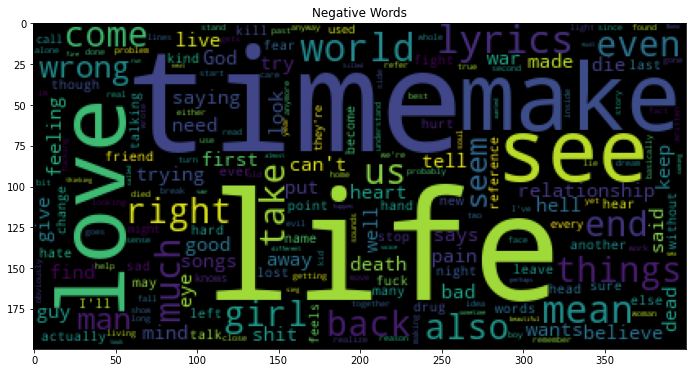

In [98]:
# Negative Comments
Comments_text3 = song_comments_df_1[song_comments_df_1['Comment_sentiment_vader'] < -0.3]['Comment'].fillna('Not available')
docs_string_comments3 = ' '.join(Comments_text3)
wc_comments3 = WordCloud(background_color='black', stopwords=common_stopwords).generate(docs_string_comments3)
plt.imshow(wc_comments3)
plt.title('Negative Words')
song_comments_df_1.iloc[:,[1,2,6]][song_comments_df_1['Comment_sentiment_vader'] < -0.3].sort_values('Comment_sentiment_vader', ascending = False, inplace = False).head()

## 9. Comparing sentiment of Song lyrics and comments

In [80]:
song_lyrics_df_1.iloc[:,[0,1,2,6,7]][song_lyrics_df_1['Song'] == 'You Can Let Go']

,ID,Artist,Song,Lyrics_sentiment_vader,Lyrics_sentiment_pred_label
1510,1511,Backstreet Boys,You Can Let Go,-0.9544,negative


,Artist,Song,Comment_sentiment_vader
21455,P.O.D.,Mark My Words (feat. Sick Jacken),-0.3001
19817,O.A.R.,The Fallout,-0.3009
3638,The B-52's,Dirty Back Road,-0.3016
24844,The Raconteurs,These Stones Will Shout,-0.3017
555,A Day to Remember,All I Want,-0.3022


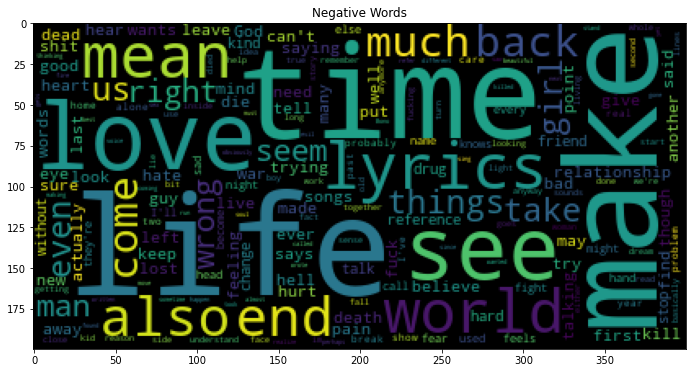

In [79]:
# Negative Comments
Comments_text3 = song_comments_df_1[song_comments_df_1['Comment_sentiment_vader'] < -0.3]['Comment'].fillna('Not available')
docs_string_comments3 = ' '.join(Comments_text3)
wc_comments3 = WordCloud(background_color='black', stopwords=common_stopwords).generate(docs_string_comments3)
plt.imshow(wc_comments3)
plt.title('Negative Words')
song_comments_df_1.iloc[:,[1,2,6]][song_comments_df_1['Comment_sentiment_vader'] < -0.3].sort_values('Comment_sentiment_vader', ascending = False, inplace = False).head()

In [81]:
song_comments_df_1.iloc[:,[0,1,2,6,7]][song_comments_df_1['Song'] == 'You Can Let Go']

,ID,Artist,Song,Comment_sentiment_vader,Comments_sentiment_pred_label
5623,1511,Backstreet Boys,You Can Let Go,0.9215,positive
5624,1511,Backstreet Boys,You Can Let Go,0.8286,positive
5625,1511,Backstreet Boys,You Can Let Go,0.8345,positive
5626,1511,Backstreet Boys,You Can Let Go,-0.9628,negative
5627,1511,Backstreet Boys,You Can Let Go,0.5551,positive


#### For the song 'You Can Let Go' has a negative sentiment but the comments for this song mostly have positive sentiment

## 10.Topic modeling on lyrics using Latent Dirichlet Allocation (LDA)

#### AIM: Transform texts to vector representation

#### Step 1 : Create dictionaries of unique words in the processed tokenized text

In [82]:
lyrics_dict = corpora.Dictionary(song_lyrics_df_1['Lyrics_tokens'])
#library used : from gensim import corpora
#This module implements the concept of a Dictionary – a mapping between words and their integer ids.
#facility of Dictionary object, which maps each word to their unique integer id. It does this by converting input text to the list of words and then pass it to the corpora.Dictionary() object.
print(len(lyrics_dict))
#print(len(comments_dict))

43858


In [83]:
print(lyrics_dict)#the uniques tokens

Dictionary(43858 unique tokens: ['alone', 'alright', 'attack', 'back', 'bag']...)


In [84]:
print(lyrics_dict.token2id)#ids assigned to the unique toekens

{'alone': 0, 'alright': 1, 'attack': 2, 'back': 3, 'bag': 4, 'bomb': 5, 'bum': 6, 'daylight': 7, 'eye': 8, 'gold': 9, 'hair': 10, 'heart': 11, 'hesitate': 12, 'im': 13, 'knee': 14, 'left': 15, 'look': 16, 'man': 17, 'mine': 18, 'money': 19, 'oclock': 20, 'ok': 21, 'old': 22, 'panic': 23, 'radio': 24, 'radioooooh': 25, 'right': 26, 'shake': 27, 'shouting': 28, 'sign': 29, 'sport': 30, 'square': 31, 'stare': 32, 'start': 33, 'stop': 34, 'subway': 35, 'suddenly': 36, 'talking': 37, 'telephone': 38, 'telling': 39, 'time': 40, 'train': 41, 'tube': 42, 'waiting': 43, 'well': 44, 'wont': 45, 'work': 46, 'alive': 47, 'bigger': 48, 'co': 49, 'count': 50, 'crowd': 51, 'eight': 52, 'finger': 53, 'five': 54, 'four': 55, 'getting': 56, 'give': 57, 'hard': 58, 'ive': 59, 'keep': 60, 'many': 61, 'moving': 62, 'need': 63, 'noise': 64, 'ready': 65, 'seven': 66, 'shaking': 67, 'six': 68, 'smaller': 69, 'taking': 70, 'taller': 71, 'three': 72, 'told': 73, 'trigger': 74, 'two': 75, 'whoah': 76, 'afterburn

#### Step 2 : Convert texts to vectors

In [85]:
lyrics_corpus=[]
for text in song_lyrics_df_1['Lyrics_tokens']:
    lyrics_corpus.append(lyrics_dict.doc2bow(text))
#doc2bow : Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples.
#Each word is assumed to be a tokenized and normalized string (either unicode or utf8-encoded). 

In [86]:
len(lyrics_corpus)

8649

In [87]:
song_lyrics_df_1['Lyrics_tokens'][1]

['im',
 'ready',
 'two',
 'many',
 'three',
 'four',
 'im',
 'count',
 'five',
 'work',
 'keep',
 'alive',
 'six',
 'seven',
 'eight',
 'ive',
 'eight',
 'finger',
 'wont',
 'bigger',
 'need',
 'trigger',
 'ive',
 'told',
 'wont',
 'taller',
 'smaller',
 'co',
 'alright',
 'moving',
 'moving',
 'im',
 'ready',
 'crowd',
 'give',
 'noise',
 'im',
 'taking',
 'hard',
 'im',
 'shaking',
 'im',
 'ready',
 'crowd',
 'ive',
 'eight',
 'finger',
 'wont',
 'bigger',
 'need',
 'trigger',
 'ive',
 'told',
 'wont',
 'taller',
 'smaller',
 'co',
 'alright',
 'whoah',
 'ive',
 'eight',
 'finger',
 'wont',
 'bigger',
 'need',
 'trigger',
 'ive',
 'told',
 'wont',
 'taller',
 'im',
 'getting',
 'smaller',
 'co',
 'alright']

In [88]:
lyrics_corpus[1]

[(1, 3),
 (13, 7),
 (45, 6),
 (46, 1),
 (47, 1),
 (48, 3),
 (49, 3),
 (50, 1),
 (51, 2),
 (52, 4),
 (53, 3),
 (54, 1),
 (55, 1),
 (56, 1),
 (57, 1),
 (58, 1),
 (59, 6),
 (60, 1),
 (61, 1),
 (62, 2),
 (63, 3),
 (64, 1),
 (65, 3),
 (66, 1),
 (67, 1),
 (68, 1),
 (69, 3),
 (70, 1),
 (71, 3),
 (72, 1),
 (73, 3),
 (74, 3),
 (75, 1),
 (76, 1)]

- Topic modeling is a method for unsupervised classification of documents, similar to clustering on numeric data, which finds some natural groups of items (topics) even when we’re not sure what we’re looking for.


- A document can be a part of multiple topics, kind of like in fuzzy clustering(soft clustering) in which each data point belongs to more than one cluster.

- Latent Dirichlet Allocation(LDA) is a popular algorithm for topic modeling with excellent implementations in the Python's Gensim package.

In [89]:
# Lyrics LDA model
lyrics_lda = gensim.models.ldamodel.LdaModel(corpus=lyrics_corpus,
                                               id2word=lyrics_dict,
                                               num_topics=50, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=1000,
                                               passes=1,
                                               alpha='auto',
                                               eta='auto')

#### Visualize lyrics topics keywords

In [90]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lyrics_lda, lyrics_corpus, lyrics_dict)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18    -0.150138 -0.075408       1        1  5.872864
12    -0.140193 -0.075358       2        1  5.724275
15    -0.149372  0.034615       3        1  5.531412
45    -0.148429  0.028269       4        1  5.023325
32    -0.024194 -0.214140       5        1  4.178892
49    -0.145805  0.004649       6        1  3.633508
25    -0.120916  0.019543       7        1  3.586145
43    -0.119096  0.032363       8        1  3.584412
38    -0.135300 -0.030510       9        1  3.560767
29    -0.059833 -0.109164      10        1  3.233322
39    -0.120407 -0.013008      11        1  3.028428
8     -0.109631 -0.044767      12        1  2.878105
27    -0.123024 -0.009795      13        1  2.759691
5     -0.102810  0.029276      14        1  2.543833
13    -0.062528  0.125320      15        1  2.335877
26    -0.077464 -0.041762      16        1  2.316992
33    -0.083377  0.035574      17        1  2.210151
24    -0.064345  0.019134      18        1  2.114552
30    -0.080245 -0.017417      19        1  1.941837
14    -0.025721  0.022284      20        1  1.938518
36    -0.049258  0.104991      21        1  1.874145
3     -0.079298  0.003963      22        1  1.821858
7     -0.068576  0.022518      23        1  1.753375
46    -0.067043  0.097903      24        1  1.619951
34     0.054895  0.020943      25        1  1.586885
47     0.060801  0.168301      26        1  1.473813
21    -0.008675  0.013191      27        1  1.453108
2      0.108120 -0.176669      28        1  1.256562
0     -0.016376  0.026768      29        1  1.246542
9      0.098625 -0.042536      30        1  1.212890
11     0.007423  0.038199      31        1  1.119640
31     0.137926 -0.132530      32        1  1.073877
37     0.083571 -0.121022      33        1  1.066957
44     0.049218 -0.031329      34        1  1.065179
6      0.052850 -0.074949      35        1  1.026701
23     0.020389 -0.010194      36        1  1.024317
35     0.000105  0.058919      37        1  1.008039
41     0.011893  0.002743      38        1  0.909824
42     0.107231 -0.084119      39        1  0.874877
28     0.033812  0.074364      40        1  0.866179
48     0.091475  0.022735      41        1  0.828878
10     0.057377  0.021300      42        1  0.786579
20     0.167848  0.001654      43        1  0.776639
40     0.201029 -0.009767      44        1  0.773945
4      0.086323  0.056187      45        1  0.689691
22     0.149429  0.064126      46        1  0.686612
1      0.188563  0.017427      47        1  0.557596
17     0.190116  0.097409      48        1  0.554552
19     0.163347  0.002234      49        1  0.517298
16     0.209688  0.047542      50        1  0.496585, topic_info=        Term          Freq         Total Category  logprob  loglift
360     love  11351.000000  11351.000000  Default  30.0000  30.0000
574       la   3654.000000   3654.000000  Default  29.0000  29.0000
368    world   3535.000000   3535.000000  Default  28.0000  28.0000
17       man   4161.000000   4161.000000  Default  27.0000  27.0000
57      give   3317.000000   3317.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
1796    shoe     69.594846    281.011742  Topic50  -4.1383   3.9095
3250  erased     24.903441     45.933808  Topic50  -5.1660   4.6930
119     year     72.929778   1261.449372  Topic50  -4.0915   2.4547
768   lookin     29.454247    300.978658  Topic50  -4.9982   2.9810
199      see     25.225187   8189.604556  Topic50  -5.1532  -0.4776

[3127 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1518     29  0.929952        aah
3228     43  0.965622    abandon
4387      2  0.019236  abandoned
4387     18  0.057709  abandoned
4387     25  0.904110  abandoned
...     ...       ...        ...
6980     19  0.025933        zip
6980     33  0.959535        zip
4183     15  0.91

#### Create vectors that represent topic distribution of each lyrics

In [91]:
lyrics_topic_vectors = lyrics_lda[lyrics_corpus]

#### Search by Artist

In [92]:
song_lyrics_df[song_lyrics_df['Artist'] == 'Backstreet Boys']

,ID,Artist,Song,Lyrics,Length
1346,1347,Backstreet Boys,"10,000 Promises",Once we were lovers \nJust lovers we were \n...,796
1347,1348,Backstreet Boys,All I Have To Give,I don't know what he does to make you cry \nBu...,1749
1348,1349,Backstreet Boys,All In My Head,Maybe it's just me \r\nBut I don't think that ...,3739
1349,1350,Backstreet Boys,All In This Together,Let me tell you what I see through my eyes \r\...,1557
1350,1351,Backstreet Boys,All of Your Life (You Need Love),"Hey \nYeah, yeah \nI wanna know \nCan we spend...",2205
...,...,...,...,...,...
1507,1508,Backstreet Boys,Who Do You Love,I know he's driving a fancy car \r\nWhen you'r...,1456
1508,1509,Backstreet Boys,Yes I Will,I open my eyes \nI see your face \nI cannot hi...,1985
1509,1510,Backstreet Boys,You Are,Beautiful you are \r\nCompassionate is she \r\...,315
1510,1511,Backstreet Boys,You Can Let Go,"I can see in your eyes \nBroken windows, falle...",1536


#### Search by Song

In [93]:
song_lyrics_df[song_lyrics_df['Song'] == 'All I Have To Give']

,ID,Artist,Song,Lyrics,Length
1347,1348,Backstreet Boys,All I Have To Give,I don't know what he does to make you cry \nBu...,1749


In [94]:
song_index = 1347

#### Recommendations based on similar lyrics

In [95]:
lyrics_sims = []
for i in np.arange(len(lyrics_topic_vectors)):
    sim = gensim.matutils.cossim(lyrics_topic_vectors[song_index], lyrics_topic_vectors[i])#Return cosine similarity between two sparse vectors.
    lyrics_sims.append(sim)
song_lyrics_df_1['Similarity to input'] = lyrics_sims

In [96]:
song_lyrics_df_1.iloc[:,[1,2,8]].sort_values(by=['Similarity to input'], ascending = False).head(10)

,Artist,Song,Similarity to input
1347,Backstreet Boys,All I Have To Give,0.999979
8150,U2,Red Light,0.773237
7645,T. Rex,Beltane Walk,0.753779
333,A Flock of Seagulls,(It's Not Me) Talking,0.742917
3921,J.R.R. Tolkien,In Western Lands,0.739236
2509,Daft Punk,Around the World,0.737349
4220,L'arc-en-ciel,Ready Steady Go (English),0.701938
1216,Babyshambles,Another Girl From Another Planet,0.696260
5989,P.O.D.,Ghetto,0.693403
1637,Céline Dion,Did You Give Enough Love,0.691989


#### For the song 'All I Have To Give' we have the above displayed recommendation

## 11.Conclusion

- Out of Million records of Lyrics and Comments, we could scrap around 42000 songs for our Analysis of which we used 8650 songs for lyrics and comment analysis

- After scraping for Lyrics we have 8650 records

- The sentiments of the song lyrics are equally distributed across positive and negative.

- Most of the reviews or comments of the song have postive sentiment.

- We found that the sentiment of lyrics and comments need not necessarily be similar.